In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_bollinger_band1(df):
    window=10
    wap_bol_upper = df["wap1"].rolling(window=window).mean() + (df["wap1"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap1"].rolling(window=window).mean() - (df["wap1"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band2(df):
    window=10
    wap_bol_upper = df["wap2"].rolling(window=window).mean() + (df["wap2"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap2"].rolling(window=window).mean() - (df["wap2"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band3(df):
    window=10
    wap_bol_upper = df["wap3"].rolling(window=window).mean() + (df["wap3"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap3"].rolling(window=window).mean() - (df["wap3"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

def calc_bollinger_band4(df):
    window=10
    wap_bol_upper = df["wap4"].rolling(window=window).mean() + (df["wap4"].rolling(window=window).std() * 2)
    wap_bol_lower = df["wap4"].rolling(window=window).mean() - (df["wap4"].rolling(window=window).std() * 2)
    wap_bol_balance = wap_bol_upper - wap_bol_lower
    return wap_bol_balance

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    df['bollinger_band_balance1'] = calc_bollinger_band1(df)
    df['bollinger_band_balance2'] = calc_bollinger_band2(df)
    df['bollinger_band_balance3'] = calc_bollinger_band3(df)
    df['bollinger_band_balance4'] = calc_bollinger_band4(df)
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max]
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [3]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 39.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [4]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [5]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

194

In [6]:
from sklearn.cluster import KMeans
# making agg features

train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

In [7]:
ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]


In [8]:
mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [9]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  import sys


In [10]:
mat1.head()

,time_id,wap1_sum_0c1,wap1_sum_1c1,wap1_sum_2c1,wap1_sum_3c1,wap1_sum_4c1,wap1_sum_5c1,wap1_sum_6c1,wap1_std_0c1,wap1_std_1c1,...,size_tau2_200_4c1,size_tau2_200_5c1,size_tau2_200_6c1,size_tau2_d_0c1,size_tau2_d_1c1,size_tau2_d_2c1,size_tau2_d_3c1,size_tau2_d_4c1,size_tau2_d_5c1,size_tau2_d_6c1
0,5,454.259460,450.296722,410.733185,350.107635,506.105530,537.815308,476.310425,0.001151,0.000885,...,0.044431,0.044926,0.041189,-0.024915,-0.024369,-0.027101,-0.033393,-0.023273,-0.023533,-0.021575
1,11,338.439728,320.296692,278.055267,233.907928,358.379181,281.177979,423.141602,0.000564,0.000475,...,0.063868,0.051484,0.037159,-0.034569,-0.033599,-0.037332,-0.052039,-0.033454,-0.026968,-0.019464
2,16,352.636505,360.082367,347.626770,256.215057,420.425507,355.364594,284.772736,0.000620,0.000490,...,0.060912,0.036405,0.065579,-0.033426,-0.037183,-0.027899,-0.049481,-0.031906,-0.019069,-0.034351
3,31,312.892395,302.954620,298.578033,231.109253,343.913910,449.594482,366.892456,0.000597,0.000615,...,0.076921,0.037837,0.045045,-0.042717,-0.038160,-0.032851,-0.045086,-0.040292,-0.019820,-0.023595
4,62,327.286407,314.466064,315.001099,210.724350,355.398346,218.791824,407.402344,0.000536,0.000439,...,0.070177,0.076425,0.037661,-0.037143,-0.037902,-0.035379,-0.047943,-0.036759,-0.040032,-0.019727


In [11]:
mat2.head()

,time_id,wap1_sum_0c1,wap1_sum_1c1,wap1_sum_2c1,wap1_sum_3c1,wap1_sum_4c1,wap1_sum_5c1,wap1_sum_6c1,wap1_std_0c1,wap1_std_1c1,...,size_tau2_200_4c1,size_tau2_200_5c1,size_tau2_200_6c1,size_tau2_d_0c1,size_tau2_d_1c1,size_tau2_d_2c1,size_tau2_d_3c1,size_tau2_d_4c1,size_tau2_d_5c1,size_tau2_d_6c1
0,4,NaN,3.001215,NaN,NaN,NaN,NaN,NaN,NaN,0.000170,...,NaN,NaN,NaN,NaN,-0.128306,NaN,NaN,NaN,NaN,NaN
1,5,454.25946,450.296722,410.733185,350.107635,506.10553,537.815308,476.310425,0.001151,0.000885,...,0.044431,0.044926,0.041189,-0.024915,-0.024369,-0.027101,-0.033393,-0.023273,-0.023533,-0.021575
2,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
mat1.columns.tolist()

['time_id',
 'wap1_sum_0c1',
 'wap1_sum_1c1',
 'wap1_sum_2c1',
 'wap1_sum_3c1',
 'wap1_sum_4c1',
 'wap1_sum_5c1',
 'wap1_sum_6c1',
 'wap1_std_0c1',
 'wap1_std_1c1',
 'wap1_std_2c1',
 'wap1_std_3c1',
 'wap1_std_4c1',
 'wap1_std_5c1',
 'wap1_std_6c1',
 'wap2_sum_0c1',
 'wap2_sum_1c1',
 'wap2_sum_2c1',
 'wap2_sum_3c1',
 'wap2_sum_4c1',
 'wap2_sum_5c1',
 'wap2_sum_6c1',
 'wap2_std_0c1',
 'wap2_std_1c1',
 'wap2_std_2c1',
 'wap2_std_3c1',
 'wap2_std_4c1',
 'wap2_std_5c1',
 'wap2_std_6c1',
 'wap3_sum_0c1',
 'wap3_sum_1c1',
 'wap3_sum_2c1',
 'wap3_sum_3c1',
 'wap3_sum_4c1',
 'wap3_sum_5c1',
 'wap3_sum_6c1',
 'wap3_std_0c1',
 'wap3_std_1c1',
 'wap3_std_2c1',
 'wap3_std_3c1',
 'wap3_std_4c1',
 'wap3_std_5c1',
 'wap3_std_6c1',
 'wap4_sum_0c1',
 'wap4_sum_1c1',
 'wap4_sum_2c1',
 'wap4_sum_3c1',
 'wap4_sum_4c1',
 'wap4_sum_5c1',
 'wap4_sum_6c1',
 'wap4_std_0c1',
 'wap4_std_1c1',
 'wap4_std_2c1',
 'wap4_std_3c1',
 'wap4_std_4c1',
 'wap4_std_5c1',
 'wap4_std_6c1',
 'log_return1_realized_volatility_0c

In [13]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1'] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [14]:
import gc
del mat1,mat2
gc.collect()

391

In [15]:
from sklearn.model_selection import KFold
import lightgbm as lgb

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs':-1,
    }
seed2 = 29
params2 = {
        'learning_rate': 0.15,        
        'lambda_l1': 2.154360665259325,
        'lambda_l2': 6.711089761523827,
        'num_leaves': 2769,
        'min_sum_hessian_in_leaf': 20.44437160769411,
        'feature_fraction': 0.7921473067441019,
        'feature_fraction_bynode': 0.8083803860191322,
        'bagging_fraction': 0.9726755660563261,
        'bagging_freq': 42,
        'min_data_in_leaf': 1690,
        'max_depth': 4,
        'seed': seed2,
        'feature_fraction_seed': seed2,
        'bagging_seed': seed2,
        'drop_seed': seed2,
        'data_random_seed': seed2,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    } 
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params,boost=1000):
    # Hyperparammeters (just basic)
    
    evals_result = {}
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=boost,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe,
                          evals_result=evals_result)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    #lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions,model,evals_result

In [16]:
%%time
# Traing and evaluate
#predictions_lgb= train_and_evaluate_lgb(train, test,params0)
predictions_lgb2,model,evals_result= train_and_evaluate_lgb(train, test,params2,boost=10000)

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.000429995	training's RMSPE: 0.198864	valid_1's rmse: 0.00044097	valid_1's RMSPE: 0.204673
[500]	training's rmse: 0.000411379	training's RMSPE: 0.190254	valid_1's rmse: 0.00042727	valid_1's RMSPE: 0.198315
[750]	training's rmse: 0.000400295	training's RMSPE: 0.185128	valid_1's rmse: 0.000419939	valid_1's RMSPE: 0.194912
[1000]	training's rmse: 0.000392005	training's RMSPE: 0.181294	valid_1's rmse: 0.000414918	valid_1's RMSPE: 0.192582
[1250]	training's rmse: 0.000385506	training's RMSPE: 0.178289	valid_1's rmse: 0.000411923	valid_1's RMSPE: 0.191191
[1500]	training's rmse: 0.000380417	training's RMSPE: 0.175935	valid_1's rmse: 0.00040993	valid_1's RMSPE: 0.190266
[1750]	training's rmse: 0.000376024	training's RMSPE: 0.173903	valid_1's rmse: 0.000408424	valid_1's RMSPE: 0.189567
[2000]	training's rmse: 0.000371886	training's RMSPE: 0.17199	valid_1's rmse: 0.000407191	valid_1's RMSPE: 0.1

In [17]:
test['target'] = predictions_lgb2
test[['row_id', 'target']].to_csv('submission.csv',index = False)

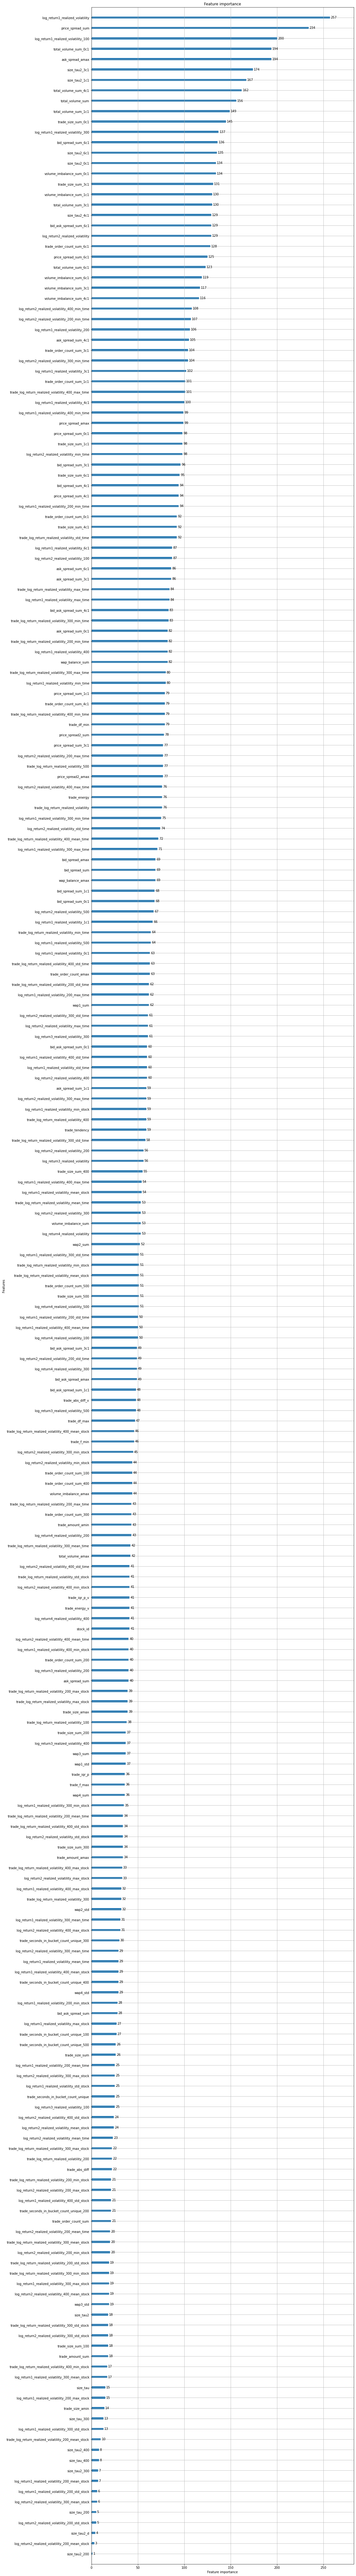

In [18]:
import matplotlib.pyplot as plt
fig,ax =plt.subplots(figsize=(15,150))
lgb.plot_importance(model,ax=ax)
plt.show()

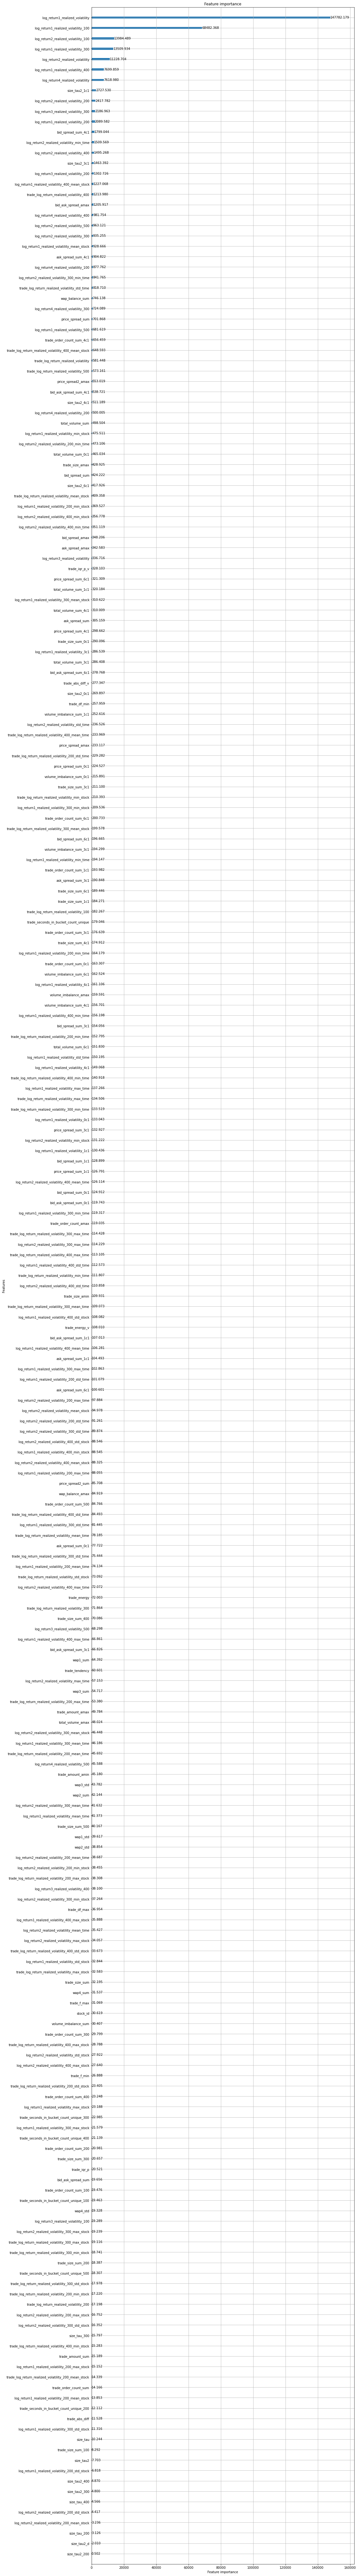

In [19]:
fig,ax =plt.subplots(figsize=(15,150))
lgb.plot_importance(model,ax=ax,importance_type="gain")
plt.show()

Plotting metrics recorded during training...


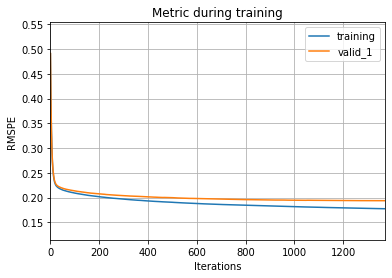

In [20]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='RMSPE')
plt.show()

Plotting metrics recorded during training...


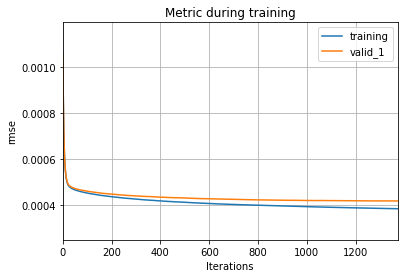

In [21]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()